In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import arch
from statsmodels.graphics.tsaplots import plot_acf
from numpy import exp,sqrt
from scipy.stats import norm
import scipy.stats as scs
import statsmodels.tsa.api as smt
import os
import sys
import pandas as pd
#import pandas_datareader.data as pdr
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
import matplotlib.pyplot as plt
import matplotlib as mpl


%matplotlib inline

In [2]:
data = pd.read_csv('Google.csv', delimiter=';')
data.index = list(data['Date'])

forecast_horizon = 30

In [3]:
df = data[['Date', 'Close']]
df['daily_returns'] = np.log(df.Close / df.Close.shift(1)) * 100            # Daily log returns
df['monthly_std'] = df['daily_returns'].rolling(21).std()   # Standard deviation across trading month
df['annual_vol'] = df['monthly_std'] * np.sqrt(252)         # Annualize monthly standard devation
df = df.dropna().reset_index(drop=True)

train = df[:-forecast_horizon]
train.index = list(train['Date'])
test = df[-forecast_horizon:]
test.index = list(test['Date'])

<ipython-input-3-7d61eb1653b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['daily_returns'] = np.log(df.Close / df.Close.shift(1)) * 100            # Daily log returns
<ipython-input-3-7d61eb1653b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['monthly_std'] = df['daily_returns'].rolling(21).std()   # Standard deviation across trading month
<ipython-input-3-7d61eb1653b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [4]:
df

,Date,Close,daily_returns,monthly_std,annual_vol
0,20.09.2004,119.36,1.579091,2.626767,41.698639
1,21.09.2004,117.84,-1.281636,2.146086,34.068065
2,22.09.2004,118.38,0.457202,2.141763,33.999440
3,23.09.2004,120.82,2.040205,1.889971,30.002363
4,24.09.2004,119.83,-0.822776,1.915095,30.401187
...,...,...,...,...,...
3099,10.01.2017,826.01,-0.141545,0.808032,12.827109
3100,11.01.2017,829.86,0.465013,0.724591,11.502530
3101,12.01.2017,829.53,-0.039774,0.722093,11.462874
3102,13.01.2017,830.94,0.169831,0.699223,11.099823


In [5]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        '''qq_ax.set_title('QQ Plot')
        kde_pdf = scs.gaussian_kde(y)
        x= np.linspace(min(y), max(y), len(y))
        bins=np.arange(min(y), max(y),0.5)
        pp_ax.plot(x,scs.norm.pdf(x,scs.tmean(y),scs.tstd(y)),label="parametric distribution",color="red")
        pp_ax.plot(x,kde_pdf(x),'r',label="KDE estimation",color="blue")
        pp_ax.hist(y,bins=bins,density = True,color="gray",alpha=.6, label='data histogram')
        pp_ax.set_title("Probability density function")
        pp_ax.legend()'''
        plt.tight_layout()
    plt.show()
    return 

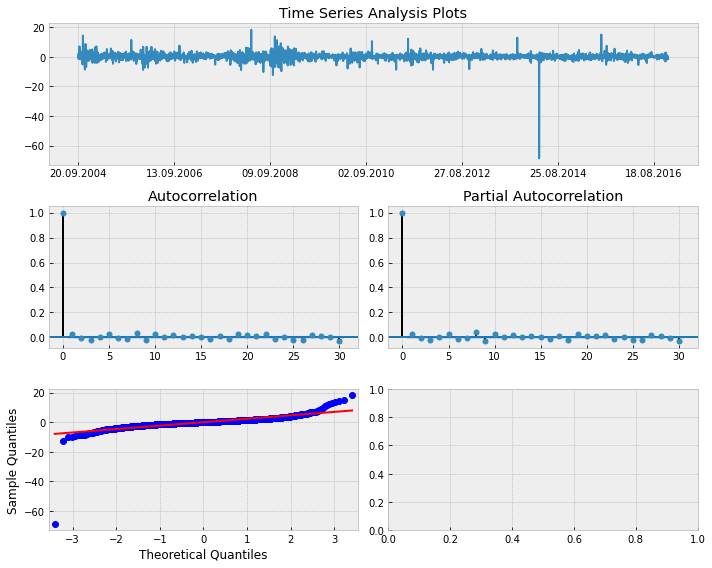

In [6]:
_=tsplot(train['daily_returns'], lags=30)

In [7]:
#GARCH
#am=arch_model(train['Close'])
am=arch_model(train['daily_returns'])
res = am.fit(disp='off')
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:          daily_returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -6896.58
Distribution:                  Normal   AIC:                           13801.2
Method:            Maximum Likelihood   BIC:                           13825.3
                                        No. Observations:                 3074
Date:                Thu, Dec 17 2020   Df Residuals:                     3070
Time:                        15:25:21   Df Model:                            4
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1085  5.808e-02      1.869  6.162e-02 [-5.28

In [8]:
import statsmodels.stats.diagnostic as smd

smd.het_arch(res.resid)

C:\Users\User\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:622: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  warnings.warn("The default value of nlags is changing.  After 0.12, "


(0.19483988655421836, 1.0, 0.006652849203695512, 0.9999999999999999)

In [9]:
resids = res.resid**2

for i in range(len(resids)):
    if resids[i] > 800:
        resids[i] = 800

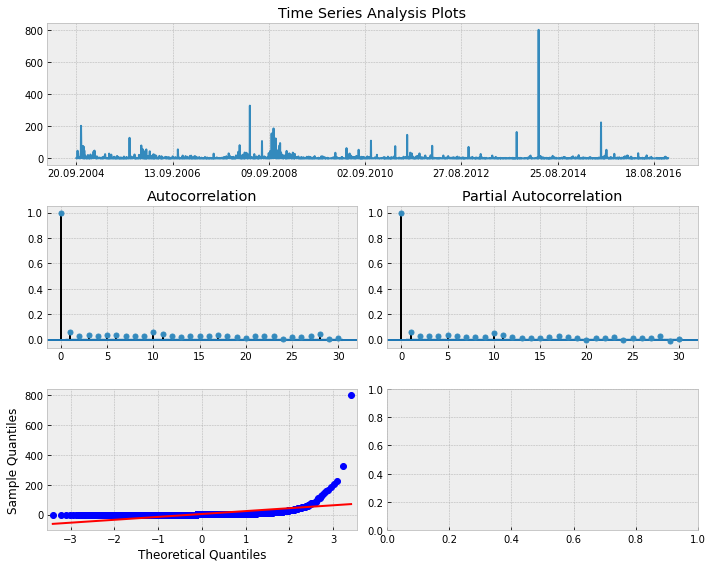

In [10]:
_=tsplot(resids, lags=30)

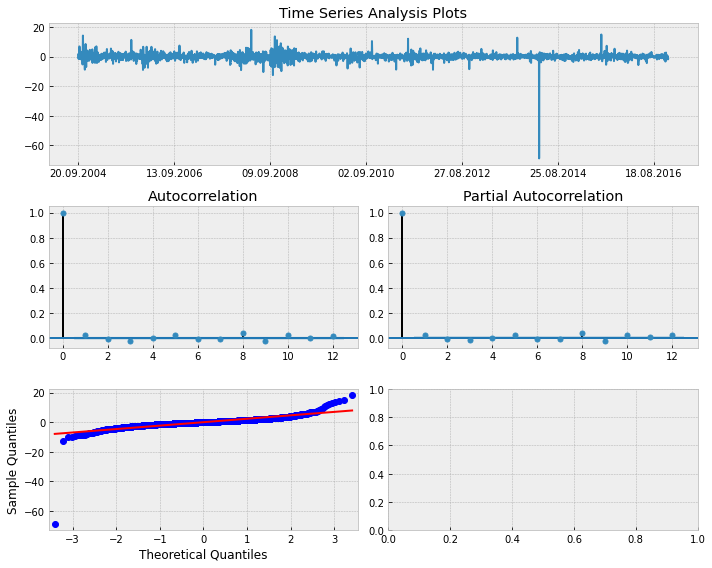

In [11]:
_=tsplot(res.resid, lags=12)

In [12]:
def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def theil(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true_sq = np.sqrt(np.sum(y_true**2)/y_true.size)
    y_pred_sq = np.sqrt(np.sum(y_pred**2)/y_pred.size)
    y_sq = np.sqrt(np.mean((y_true - y_pred)**2))
    return y_sq/(y_true_sq+y_pred_sq)

def mdl_conclusion(res):
    res_ser = pd.Series()
    res_ser = pd.Series(res.params).append([res.pvalues, pd.Series(res.model, index=['MDL']),pd.Series([res.nobs, res.loglikelihood, res.aic, res.bic], index=['Num', 'LL', 'AIC', 'BIC'])])
    return res_ser

In [13]:
###result is the same as previous
#GARCH garch = GARCH(p=1, q=1)
# gjr = GARCH(p=1, o=1, q=1)
#tarch = GARCH(p=1, o=1, q=1, power=1.0)

# TARCH

from arch.univariate import ConstantMean, GARCH, Normal, StudentsT
am = ConstantMean(train['daily_returns'])
am.volatility = GARCH(p=1, o=1, q=1, power=1.0)
am.distribution = StudentsT()
#am.distribution = Normal()
res = am.fit(disp='off')
print(res.summary())

                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                daily_returns   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -5839.74
Distribution:      Standardized Student's t   AIC:                           11691.5
Method:                  Maximum Likelihood   BIC:                           11727.7
                                              No. Observations:                 3074
Date:                      Thu, Dec 17 2020   Df Residuals:                     3068
Time:                              15:25:25   Df Model:                            6
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [14]:
end_loc = 1500
res_test = am.fix(res.params.values, last_obs=end_loc)
pred_test = res_test.forecast(horizon=1, align = 'origin').variance
print(pred_test.shift(1)[end_loc:])

                 h.1
02.09.2010  3.714404
03.09.2010  3.424661
07.09.2010  3.340973
08.09.2010  3.449259
09.09.2010  3.323919
...              ...
25.11.2016  2.807777
28.11.2016  2.538310
29.11.2016  2.390830
30.11.2016  2.219013
01.12.2016  2.529264

[1574 rows x 1 columns]


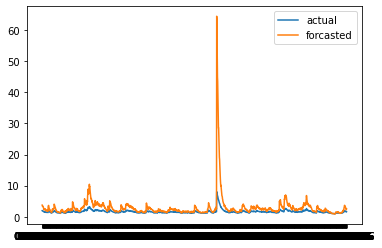

In [15]:
sample_var = res.conditional_volatility[end_loc:]
forcasted_var = pred_test.shift(1)[end_loc:]
#forcasted_var = pd.DataFrame(forecasts).T['h.1']
#df = pd.concat([sample_var,forcasted_var],1)
#df.columns = ['actual', 'forecasted']
plt.plot(sample_var, label = 'actual')
plt.plot(forcasted_var, label = 'forcasted')
plt.legend()
plt.show()

In [16]:
print('mae:', mae(sample_var, forcasted_var))
print('mape:', mape(sample_var, forcasted_var))
print('theil:', theil(sample_var, forcasted_var))

mae: 1.4992026376955425
mape: 1.0056872870338982
theil: 0.6392296443862254


In [17]:
###result is the same as previous
#GARCH garch = GARCH(p=1, q=1)
# gjr = GARCH(p=1, o=1, q=1)
#tarch = GARCH(p=1, o=1, q=1, power=1.0)

# GARCH

from arch.univariate import ConstantMean, GARCH, Normal, StudentsT
am = ConstantMean(train['daily_returns'])
am.volatility = GARCH(p=1, q=1)
am.distribution = StudentsT()
#am.distribution = Normal()
res = am.fit(disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                daily_returns   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -5890.30
Distribution:      Standardized Student's t   AIC:                           11790.6
Method:                  Maximum Likelihood   BIC:                           11820.8
                                              No. Observations:                 3074
Date:                      Thu, Dec 17 2020   Df Residuals:                     3069
Time:                              15:25:52   Df Model:                            5
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

                 h.1
02.09.2010  3.096661
03.09.2010  2.860380
07.09.2010  2.839261
08.09.2010  2.797613
09.09.2010  2.730501
...              ...
25.11.2016  2.660913
28.11.2016  2.460048
29.11.2016  2.326867
30.11.2016  2.188120
01.12.2016  2.398047

[1574 rows x 1 columns]
mae: 3.5565955293955
mape: 2.1811228271693697
theil: 0.9038471532080781


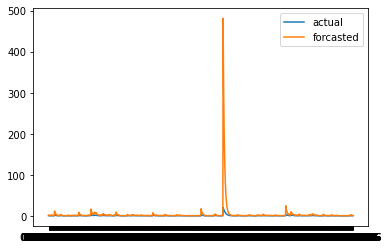

In [18]:
end_loc = 1500
res_test = am.fix(res.params.values, last_obs=end_loc)
pred_test = res_test.forecast(horizon=1, align = 'origin').variance
print(pred_test.shift(1)[end_loc:])

sample_var = res.conditional_volatility[end_loc:]
forcasted_var = pred_test.shift(1)[end_loc:]
#forcasted_var = pd.DataFrame(forecasts).T['h.1']
#df = pd.concat([sample_var,forcasted_var],1)
#df.columns = ['actual', 'forecasted']

print('mae:', mae(sample_var, forcasted_var))
print('mape:', mape(sample_var, forcasted_var))
print('theil:', theil(sample_var, forcasted_var))

plt.plot(sample_var, label = 'actual')
plt.plot(forcasted_var, label = 'forcasted')
plt.legend()
plt.show()

In [19]:
###result is the same as previous
#GARCH garch = GARCH(p=1, q=1)
# gjr = GARCH(p=1, o=1, q=1)
#tarch = GARCH(p=1, o=1, q=1, power=1.0)

# gjr - GARCH

from arch.univariate import ConstantMean, GARCH, Normal, StudentsT
am = ConstantMean(train['daily_returns'])
am.volatility = GARCH(p=1, o=1, q=1)
am.distribution = StudentsT()
#am.distribution = Normal()
res = am.fit(disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                daily_returns   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5884.44
Distribution:      Standardized Student's t   AIC:                           11780.9
Method:                  Maximum Likelihood   BIC:                           11817.1
                                              No. Observations:                 3074
Date:                      Thu, Dec 17 2020   Df Residuals:                     3068
Time:                              15:26:23   Df Model:                            6
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

                 h.1
02.09.2010  3.224757
03.09.2010  2.925896
07.09.2010  2.793762
08.09.2010  2.850211
09.09.2010  2.694443
...              ...
25.11.2016  2.752185
28.11.2016  2.511764
29.11.2016  2.335852
30.11.2016  2.172192
01.12.2016  2.588331

[1574 rows x 1 columns]
mae: 4.5733622604212405
mape: 2.8134747742747646
theil: 0.9325831965064671


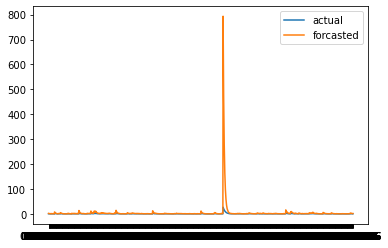

In [20]:
end_loc = 1500
res_test = am.fix(res.params.values, last_obs=end_loc)
pred_test = res_test.forecast(horizon=1, align = 'origin').variance
print(pred_test.shift(1)[end_loc:])

sample_var = res.conditional_volatility[end_loc:]
forcasted_var = pred_test.shift(1)[end_loc:]
#forcasted_var = pd.DataFrame(forecasts).T['h.1']
#df = pd.concat([sample_var,forcasted_var],1)
#df.columns = ['actual', 'forecasted']

print('mae:', mae(sample_var, forcasted_var))
print('mape:', mape(sample_var, forcasted_var))
print('theil:', theil(sample_var, forcasted_var))

plt.plot(sample_var, label = 'actual')
plt.plot(forcasted_var, label = 'forcasted')
plt.legend()
plt.show()

In [21]:
#egarch = EGARCH(p=1, q=1)
#egarch = EGARCH(p=1, o=1, q=1)
#exponential arch process: earch = EGARCH(p=5)
from arch.univariate import EGARCH
am = ConstantMean(train['daily_returns'])
am.volatility = EGARCH(p=1, o=1, q=1)
am.distribution = StudentsT()
#am.distribution = Normal()
res = am.fit(disp='off')
print(res.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                daily_returns   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -5863.21
Distribution:      Standardized Student's t   AIC:                           11738.4
Method:                  Maximum Likelihood   BIC:                           11774.6
                                              No. Observations:                 3074
Date:                      Thu, Dec 17 2020   Df Residuals:                     3068
Time:                              15:26:55   Df Model:                            6
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

                 h.1
02.09.2010  3.497248
03.09.2010  3.395507
07.09.2010  3.417658
08.09.2010  3.409699
09.09.2010  3.404324
...              ...
25.11.2016  2.101281
28.11.2016  2.016524
29.11.2016  1.991022
30.11.2016  1.941946
01.12.2016  2.024635

[1574 rows x 1 columns]
mae: 1.5033401586302306
mape: 0.9733968867228744
theil: 0.5902187659682393


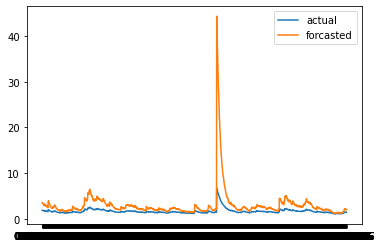

In [22]:
end_loc = 1500
res_test = am.fix(res.params.values, last_obs=end_loc)
pred_test = res_test.forecast(horizon=1, align = 'origin').variance
print(pred_test.shift(1)[end_loc:])

sample_var = res.conditional_volatility[end_loc:]
forcasted_var = pred_test.shift(1)[end_loc:]
#forcasted_var = pd.DataFrame(forecasts).T['h.1']
#df = pd.concat([sample_var,forcasted_var],1)
#df.columns = ['actual', 'forecasted']

print('mae:', mae(sample_var, forcasted_var))
print('mape:', mape(sample_var, forcasted_var))
print('theil:', theil(sample_var, forcasted_var))

plt.plot(sample_var, label = 'actual')
plt.plot(forcasted_var, label = 'forcasted')
plt.legend()
plt.show()

In [23]:
#egarch = EGARCH(p=1, q=1)
#egarch = EGARCH(p=1, o=1, q=1)
#exponential arch process: earch = EGARCH(p=5)
from arch.univariate import EGARCH
am = ConstantMean(train['daily_returns'])
am.volatility = EGARCH(p=1, q=1)
am.distribution = StudentsT()
#am.distribution = Normal()
res = am.fit(disp='off')
print(res.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                daily_returns   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -5863.30
Distribution:      Standardized Student's t   AIC:                           11736.6
Method:                  Maximum Likelihood   BIC:                           11766.8
                                              No. Observations:                 3074
Date:                      Thu, Dec 17 2020   Df Residuals:                     3069
Time:                              15:27:26   Df Model:                            5
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

                 h.1
02.09.2010  3.528333
03.09.2010  3.422445
07.09.2010  3.434721
08.09.2010  3.433855
09.09.2010  3.420072
...              ...
25.11.2016  2.131709
28.11.2016  2.045978
29.11.2016  2.017031
30.11.2016  1.965829
01.12.2016  2.056458

[1574 rows x 1 columns]
mae: 1.5552672925652238
mape: 1.0026105474041758
theil: 0.6149507000235753


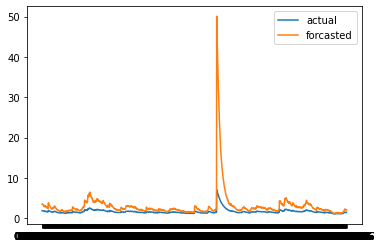

In [24]:
end_loc = 1500
res_test = am.fix(res.params.values, last_obs=end_loc)
pred_test = res_test.forecast(horizon=1, align = 'origin').variance
print(pred_test.shift(1)[end_loc:])

sample_var = res.conditional_volatility[end_loc:]
forcasted_var = pred_test.shift(1)[end_loc:]
#forcasted_var = pd.DataFrame(forecasts).T['h.1']
#df = pd.concat([sample_var,forcasted_var],1)
#df.columns = ['actual', 'forecasted']

print('mae:', mae(sample_var, forcasted_var))
print('mape:', mape(sample_var, forcasted_var))
print('theil:', theil(sample_var, forcasted_var))

plt.plot(sample_var, label = 'actual')
plt.plot(forcasted_var, label = 'forcasted')
plt.legend()
plt.show()

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
numpy.random.seed(7)

In [26]:
dataset = forcasted_var['h.1'].apply(lambda x: (x - min(forcasted_var['h.1'])) / (max(forcasted_var['h.1']) - min(forcasted_var['h.1'])))
target = sample_var.apply(lambda x: (x - min(sample_var)) / (max(sample_var) - min(sample_var)))

In [27]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size

train = dataset[0:train_size]
test = dataset[train_size:len(dataset)]

target_train = target[0:train_size]
target_test = target[train_size:len(target)]

len(train), len(test), len(target_train), len(target_test)

(1101, 473, 1101, 473)

In [28]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX), numpy.array(dataY)

In [29]:
look_back = 1
trainX, trainY = create_dataset(list(target_train), look_back)
testX, testY = create_dataset(list(target_test), look_back)

In [30]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1099/1099 - 3s - loss: 0.0073
Epoch 2/100
1099/1099 - 3s - loss: 0.0029
Epoch 3/100
1099/1099 - 3s - loss: 0.0010
Epoch 4/100
1099/1099 - 3s - loss: 8.7579e-04
Epoch 5/100
1099/1099 - 3s - loss: 8.7089e-04
Epoch 6/100
1099/1099 - 3s - loss: 8.8461e-04
Epoch 7/100
1099/1099 - 3s - loss: 8.7701e-04
Epoch 8/100
1099/1099 - 3s - loss: 8.8182e-04
Epoch 9/100
1099/1099 - 3s - loss: 8.7642e-04
Epoch 10/100
1099/1099 - 3s - loss: 8.7884e-04
Epoch 11/100
1099/1099 - 3s - loss: 8.7145e-04
Epoch 12/100
1099/1099 - 3s - loss: 8.7246e-04
Epoch 13/100
1099/1099 - 3s - loss: 8.7196e-04
Epoch 14/100
1099/1099 - 3s - loss: 8.7755e-04
Epoch 15/100
1099/1099 - 3s - loss: 8.7607e-04
Epoch 16/100
1099/1099 - 3s - loss: 8.7682e-04
Epoch 17/100
1099/1099 - 3s - loss: 8.7763e-04
Epoch 18/100
1099/1099 - 3s - loss: 8.7548e-04
Epoch 19/100
1099/1099 - 3s - loss: 8.7222e-04
Epoch 20/100
1099/1099 - 3s - loss: 8.7908e-04
Epoch 21/100
1099/1099 - 3s - loss: 8.7681e-04
Epoch 22/100
1099/1099 - 3s - loss

In [32]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [33]:
trainPredict = trainPredict.reshape(1, len(trainPredict))[0]
testPredict = testPredict.reshape(1, len(testPredict))[0]

pred_train = []
pred_test = []
y_train = []
y_test = []

'''for i in range(len(trainPredict)):
    pred_train.append(trainPredict[i] * (max(forcasted_var['h.1']) - min(forcasted_var['h.1'])) + min(forcasted_var['h.1']))
    y_train.append(trainY[i] * (max(forcasted_var['h.1']) - min(forcasted_var['h.1'])) + min(forcasted_var['h.1']))
    
for i in range(len(testPredict)):
    pred_test.append(testPredict[i] * (max(forcasted_var['h.1']) - min(forcasted_var['h.1'])) + min(forcasted_var['h.1']))
    y_test.append(testY[i] * (max(forcasted_var['h.1']) - min(forcasted_var['h.1'])) + min(forcasted_var['h.1']))'''
    
for i in range(len(trainPredict)):
    pred_train.append(trainPredict[i] * (max(sample_var) - min(sample_var)) + min(sample_var))
    y_train.append(trainY[i] * (max(sample_var) - min(sample_var)) + min(sample_var))
    
for i in range(len(testPredict)):
    pred_test.append(testPredict[i] * (max(sample_var) - min(sample_var)) + min(sample_var))
    y_test.append(testY[i] * (max(sample_var) - min(sample_var)) + min(sample_var))


trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

trainScore = math.sqrt(mean_squared_error(y_train, pred_train))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, pred_test))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.01 RMSE
Train Score: 0.18 RMSE
Test Score: 0.04 RMSE


In [34]:
print('mae:', mae(y_train, pred_train))
print('mae_test:', mae(y_test, pred_test))
print('mape:', mape(y_train, pred_train))
print('mape_test:', mape(y_test, pred_test))
print('theil:', theil(y_train, pred_train))
print('theil_test:', theil(y_test, pred_test))

mae: 0.03544409849428016
mae_test: 0.02851881267769697
mape: 0.01834308214907511
mape_test: 0.01839527764024947
theil: 0.04842872571757328
theil_test: 0.013514680369286542


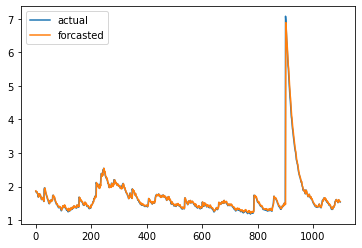

In [35]:
plt.plot(y_train, label = 'actual')
plt.plot(pred_train, label = 'forcasted')
plt.legend()
plt.show()

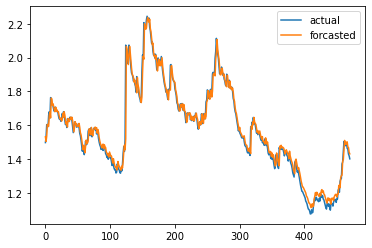

In [37]:
plt.plot(y_test, label = 'actual')
plt.plot(pred_test, label = 'forcasted')
plt.legend()
plt.show()

In [34]:
describe_stat = scs.describe(train['daily_returns'])
describe_stat

DescribeResult(nobs=3074, minmax=(-68.62115485264283, 18.225111193463892), mean=0.06091888124599257, variance=5.378500699217493, skewness=-8.052121995040999, kurtosis=253.89591230349782)